In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
import seaborn as sns
from tqdm import tqdm

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import data_quality_checks

In [4]:
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
company_df = pd.read_csv('all_retailer_company.csv',index_col = 0)
company_df.columns = ['company_name','company_identifier','state','licenses']
company_df['company_identifier'] = company_df['company_identifier'].astype(str)

In [6]:
company_df_clean = company_df[~company_df['company_identifier'].isin(['PL','WHT','GF','UR'])]
company_df.shape

(66, 4)

In [7]:
len(company_df['company_identifier'].unique())

66

In [8]:
company_df

,company_name,company_identifier,state,licenses
0,99 High Tide,99HT,CA,C10-0000279-LIC
1,Altum LLC,ALT,MI,PC-000310;AU-R-000380
2,Bella Sol,BS,MI,PC-000185;AU-R-000156
3,Big Medicine Cannabissary,BMC,CO,402-00930
4,Boston Bud Factory,BBF,MA,MR281525
...,...,...,...,...
61,Universal Herbal Health Center,UHHC,CA,C10-0000817-LIC;C9-0000082-LIC
62,Uprooted (San Ysidro),UR,CA,C10-0000731-LIC;C10-0000776-LIC;C10-0000246-LI...
63,Verts,VS,CO,402-00840;402R-00545
64,Voyage,VOY,CA,C12-0000030-LIC;C10-0000802-LIC;C12-0000159-LIC


In [92]:
company_df['lic_list'] = [list(company_df['licenses'])[i].split(";") for i in range(len(company_df))]

In [288]:
company_df

,company_name,company_identifier,state,licenses,lic_list
0,99 High Tide,99HT,CA,C10-0000279-LIC,[C10-0000279-LIC]
1,Altum LLC,ALT,MI,PC-000310;AU-R-000380,"[PC-000310, AU-R-000380]"
2,Bella Sol,BS,MI,PC-000185;AU-R-000156,"[PC-000185, AU-R-000156]"
3,Big Medicine Cannabissary,BMC,CO,402-00930,[402-00930]
4,Boston Bud Factory,BBF,MA,MR281525,[MR281525]
...,...,...,...,...,...
61,Universal Herbal Health Center,UHHC,CA,C10-0000817-LIC;C9-0000082-LIC,"[C10-0000817-LIC, C9-0000082-LIC]"
62,Uprooted (San Ysidro),UR,CA,C10-0000731-LIC;C10-0000776-LIC;C10-0000246-LI...,"[C10-0000731-LIC, C10-0000776-LIC, C10-0000246..."
63,Verts,VS,CO,402-00840;402R-00545,"[402-00840, 402R-00545]"
64,Voyage,VOY,CA,C12-0000030-LIC;C10-0000802-LIC;C12-0000159-LIC,"[C12-0000030-LIC, C10-0000802-LIC, C12-0000159..."


In [285]:
len(company_df['company_identifier'].unique())

66

# vc

In [30]:

VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-03-01'
VC_MONTH_LIST = ['2021-11-01','2021-12-01','2022-01-01','2022-02-01']
VC_MONTH_LIST_SHORT = ['2022-01-01','2022-02-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [84]:
def calculate_vendor_churn(incoming_transfer_df,license_list,vc_start_date,vc_end_date,vc_month_list,vc_month_end):
    df_vendor_churn = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]
    df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
    vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
    vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

    vc_full = (
        vc
        .groupby('shipper_facility_name').apply(
            lambda df: df.merge(
            pd.Series(
                None, 
                index = pd.date_range(start = vc_start_date, end = vc_end_date, freq = 'MS'), 
                name='__place_holder'
            ), 
            how ='right',
            left_on = 'year_month', 
            right_index=True,
        ).assign(
            **{
                "shipper_facility_name": lambda df_: df_.shipper_facility_name.dropna().unique()[0],
                "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
            }
        )
        .drop('__place_holder', axis=1)
        )
    ).reset_index(drop=True)
    
    rolling_4m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(4).sum()
    )
    rolling_4m_sum.columns = ['rolling_4m_total_price']
    facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
        lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].cumsum().to_frame()
    )
    facility_monthly_running_total.columns = ['facility_running_total']
    monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
    monthly_running_total.columns = ['monthly_running_total']

    vc_result = rolling_4m_sum.merge(
        facility_monthly_running_total,
        how='inner',
        left_index=True,
        right_index=True
    ).reset_index().merge(
        monthly_running_total,
        how='left',
        on = 'year_month'
    )
    vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
    vc_result['last_4m_active'] = vc_result['rolling_4m_total_price'] > 0
    vc_result ['significant'] = vc_result['%_total'] > 0.001
    vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
    )
    #churn
    churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
    churn.columns = ['year_month','%_inactive']
    churn.index = churn.year_month
    
    # output vendor churn matrix
    vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
    vc_data['year_month'] = vc_data['year_month'].astype(str)
    vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
    columns='year_month', fill_value=0).reset_index()
    vc_matrix['facility_total'] = vc_matrix.sum(axis= 1)
    vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
    vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
    vc_matrix['last_4m_total'] = vc_matrix[VC_MONTH_LIST].sum(axis = 1)
    vc_matrix['last_4m_active'] = vc_matrix['last_4m_total'] > 0
    vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
    vc_matrix['measure'] = vc_matrix.apply(
        lambda row: "Active"  if (row['last_4m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
        axis=1
    )
    return churn, vc_matrix


In [109]:
def calculate_vendor_churn_short(incoming_transfer_df,license_list,vc_start_date,vc_end_date,vc_month_list,vc_month_end):
    df_vendor_churn = incoming_transfer_df[incoming_transfer_df['license_number'].isin(license_list)]
    df_vendor_churn['year_month'] = pd.to_datetime(df_vendor_churn['created_date']).dt.strftime("%Y-%m")
    vc = df_vendor_churn[['year_month','shipper_facility_name','shipper_wholesale_price']].groupby(['year_month','shipper_facility_name']).sum().reset_index()
    vc= vc.assign(year_month=lambda df:pd.to_datetime(df['year_month']))

    vc_full = (
        vc
        .groupby('shipper_facility_name').apply(
            lambda df: df.merge(
            pd.Series(
                None, 
                index = pd.date_range(start = vc_start_date, end = vc_end_date, freq = 'MS'), 
                name='__place_holder'
            ), 
            how ='right',
            left_on = 'year_month', 
            right_index=True,
        ).assign(
            **{
                "shipper_facility_name": lambda df_: df_.shipper_facility_name.dropna().unique()[0],
                "shipper_wholesale_price": lambda df_: df_.shipper_wholesale_price.fillna(0),
            }
        )
        .drop('__place_holder', axis=1)
        )
    ).reset_index(drop=True)
    
    #rolling_2m_sum
    rolling_2m_sum =  vc_full.groupby('shipper_facility_name').apply(
    lambda df: df.set_index('year_month').sort_index().rolling(2).sum()
    )
    rolling_2m_sum.columns = ['rolling_2m_total_price']
    
    #facility_monthly_running_total
    facility_monthly_running_total = vc_full.groupby('shipper_facility_name').apply(
        lambda df: df.set_index('year_month').sort_index()['shipper_wholesale_price'].rolling(window = 12).sum().to_frame()
    )
    facility_monthly_running_total.columns = ['facility_running_total']
    
    #monthly_running_total
    monthly_running_total = facility_monthly_running_total.reset_index().groupby('year_month')['facility_running_total'].sum().to_frame()
    monthly_running_total.columns = ['monthly_running_total']

    vc_result = rolling_2m_sum.merge(
        facility_monthly_running_total,
        how='inner',
        left_index=True,
        right_index=True
    ).reset_index().merge(
        monthly_running_total,
        how='left',
        on = 'year_month'
    )
    vc_result['%_total'] = vc_result['facility_running_total'] / vc_result['monthly_running_total']
    vc_result['last_2m_active'] = vc_result['rolling_2m_total_price'] > 0
    vc_result ['significant'] = vc_result['%_total'] > 0.001
    vc_result['measure'] = vc_result.apply(
    lambda row: "Active"  if (row['last_2m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
    axis=1
    )
    #churn
    churn = vc_result.groupby(['year_month']).apply(lambda x: x[x['measure'] == 'Inactive']['%_total'].sum()).reset_index()
    churn.columns = ['year_month','%_inactive']
    churn.index = churn.year_month
    
    # output vendor churn matrix
    vc_data = vc_full[vc_full['year_month'] <= VC_MONTH_END]
    vc_data['year_month'] = vc_data['year_month'].astype(str)
    vc_matrix = pd.pivot_table(vc_data, values='shipper_wholesale_price', index='shipper_facility_name',
    columns='year_month', fill_value=0).reset_index()
    vc_matrix['facility_total'] = vc_matrix.iloc[: , -12:].sum(axis = 1)
    vc_matrix['grand_total'] = vc_matrix['facility_total'].sum()
    vc_matrix['perc_total'] = vc_matrix['facility_total'] / vc_matrix['grand_total']
    vc_matrix['last_2m_total'] = vc_matrix[vc_month_list].sum(axis = 1)
    vc_matrix['last_2m_active'] = vc_matrix['last_2m_total'] > 0
    vc_matrix ['significant'] = vc_matrix['perc_total'] > 0.001
    vc_matrix['measure'] = vc_matrix.apply(
        lambda row: "Active"  if (row['last_2m_active'] & row['significant']) else ("Inactive" if row['significant'] else "Exclude"),
        axis=1
    )
    return churn, vc_matrix
    


In [53]:
#df_in,df_sales_deduped,bad_dl,unknown_transfer,rwp,miss_incoming,miss_receipts = data_quality_checks.run(['EL'],TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE)




In [54]:
#lic = df_in['license_number'].unique()[0]

In [55]:
#c_short,vc_short,a_short,b_short = calculate_vendor_churn_short(df_in,[lic],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST_SHORT,VC_MONTH_END)




In [56]:
#c,vc,a,b = calculate_vendor_churn(df_in,[lic],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)




# run

In [110]:
def read_df_in(COMPANY_IDENTIFIER,license_numbers):
    company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
    )
    company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
    return company_incoming_transfer_packages_dataframe


In [111]:
def get_vc_list(company_list,transfer_packages_start_date,sales_transactrions_start_date,map_df):
    churn_df_list = {}
    vc_matrix_df_list = {}
    churn_df_list_short = {}
    vc_matrix_df_list_short = {}
    for c in tqdm(company_list):
        churn_list = {}
        vc_matrix_list = {}
        churn_list_short = {}
        vc_matrix_list_short = {}
        print(c)
        l_list = map_df[map_df['company_identifier'] == c]['lic_list'].to_list()[0]
        for l in tqdm(l_list):
            print(l)
            df_in = read_df_in([c],[l])
            if df_in.shape[0] == 0:
                churn_list[l] = numpy.nan
                vc_matrix_list[l] = numpy.nan
                churn_list_short[l] = numpy.nan
                vc_matrix_list_short[l] = numpy.nan
                continue
            else:
                churn,vc_matrix = calculate_vendor_churn(df_in,[l],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)
                churn_short,vc_matrix_short = calculate_vendor_churn_short(df_in,[l],VC_START_DATE,VC_END_DATE,VC_MONTH_LIST_SHORT,VC_MONTH_END)
                churn_list[l] = churn
                vc_matrix_list[l] = vc_matrix
                churn_list_short[l] = churn_short
                vc_matrix_list_short[l] = vc_matrix_short
        churn_df_list[c] = churn_list
        vc_matrix_df_list[c] = vc_matrix_list
        churn_df_list_short[c] = churn_list_short
        vc_matrix_df_list_short[c] = vc_matrix_list_short
    return churn_df_list,vc_matrix_df_list,churn_df_list_short,vc_matrix_df_list_short

    

    

In [112]:
c,vc,c_short,vc_short = get_vc_list(list(company_df['company_identifier']),TRANSFER_PACKAGES_START_DATE,SALES_TRANSACTIONS_START_DATE,company_df)




  0%|          | 0/66 [00:00<?, ?it/s]

99HT



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000279-LIC



  2%|▏         | 1/66 [00:01<02:02,  1.88s/it]

ALT



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000310



 50%|█████     | 1/2 [00:01<00:01,  1.13s/it]

AU-R-000380



  3%|▎         | 2/66 [00:04<02:24,  2.26s/it]

BS



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000185



 50%|█████     | 1/2 [00:01<00:01,  1.29s/it]

AU-R-000156



  5%|▍         | 3/66 [00:07<02:40,  2.55s/it]

BMC



  0%|          | 0/1 [00:00<?, ?it/s]

402-00930



  6%|▌         | 4/66 [00:08<02:08,  2.08s/it]

BBF



  0%|          | 0/1 [00:00<?, ?it/s]

MR281525



  8%|▊         | 5/66 [00:09<01:45,  1.72s/it]

BUD



  0%|          | 0/5 [00:00<?, ?it/s]

C9-0000464-LIC



 20%|██        | 1/5 [00:01<00:04,  1.24s/it]

C9-0000467-LIC



 40%|████      | 2/5 [00:02<00:03,  1.30s/it]

C9-0000444-LIC



 60%|██████    | 3/5 [00:03<00:02,  1.26s/it]

C9-0000167-LIC



 80%|████████  | 4/5 [00:05<00:01,  1.42s/it]

C9-0000399-LIC



  9%|▉         | 6/66 [00:16<03:27,  3.45s/it]

CHO



  0%|          | 0/1 [00:00<?, ?it/s]

AU-R-000575



 11%|█         | 7/66 [00:17<02:41,  2.74s/it]

CG



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000157-LIC



 12%|█▏        | 8/66 [00:19<02:22,  2.46s/it]

CPA



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000461-LIC



 50%|█████     | 1/2 [00:02<00:02,  2.80s/it]

C9-0000348-LIC



 14%|█▎        | 9/66 [00:24<02:59,  3.14s/it]

CPC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000056-LIC



 15%|█▌        | 10/66 [00:25<02:24,  2.58s/it]

CSC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000670-LIC



 50%|█████     | 1/2 [00:02<00:02,  2.37s/it]

C10-0000918-LIC



 17%|█▋        | 11/66 [00:29<02:36,  2.85s/it]

CCC



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000087-LIC



 18%|█▊        | 12/66 [00:31<02:26,  2.72s/it]

CC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000758-LIC



 20%|█▉        | 13/66 [00:33<02:04,  2.34s/it]

DWF



  0%|          | 0/1 [00:00<?, ?it/s]

402R-00804



 21%|██        | 14/66 [00:34<01:45,  2.02s/it]

DCO



  0%|          | 0/2 [00:00<?, ?it/s]

050-10052885D4C



 50%|█████     | 1/2 [00:02<00:02,  2.81s/it]

050-10070593E9E



 23%|██▎       | 15/66 [00:38<02:22,  2.80s/it]

DL



  0%|          | 0/1 [00:00<?, ?it/s]

MR283369



 24%|██▍       | 16/66 [00:40<01:58,  2.38s/it]

DGG



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000016-LIC



 26%|██▌       | 17/66 [00:41<01:42,  2.09s/it]

DG



  0%|          | 0/6 [00:00<?, ?it/s]

PC-000485



 17%|█▋        | 1/6 [00:00<00:04,  1.03it/s]

AU-R-000287



 33%|███▎      | 2/6 [00:02<00:04,  1.16s/it]

AU-R-000359



 50%|█████     | 3/6 [00:03<00:04,  1.34s/it]

AU-R-000422



 67%|██████▋   | 4/6 [00:05<00:02,  1.28s/it]

AU-R-000470



 83%|████████▎ | 5/6 [00:06<00:01,  1.20s/it]

AU-R-000572



 27%|██▋       | 18/66 [00:48<02:51,  3.57s/it]

EL



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000370-LIC



 29%|██▉       | 19/66 [00:49<02:12,  2.83s/it]

EMA



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000774-LIC



 30%|███       | 20/66 [00:52<02:00,  2.63s/it]

EMF



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000939-LIC



 32%|███▏      | 21/66 [00:53<01:41,  2.25s/it]

EMM



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000786-LIC



 33%|███▎      | 22/66 [00:55<01:34,  2.15s/it]

EMT



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000695-LIC



 35%|███▍      | 23/66 [00:57<01:30,  2.10s/it]

EH



  0%|          | 0/1 [00:00<?, ?it/s]

MR283073



 36%|███▋      | 24/66 [00:58<01:14,  1.78s/it]

FW



  0%|          | 0/5 [00:00<?, ?it/s]

402-00558



 20%|██        | 1/5 [00:01<00:05,  1.28s/it]

402R-00017



 40%|████      | 2/5 [00:03<00:05,  1.94s/it]

402-00891



 60%|██████    | 3/5 [00:05<00:03,  1.86s/it]

402R-00020



 80%|████████  | 4/5 [00:08<00:02,  2.18s/it]

402R-00747



 38%|███▊      | 25/66 [01:08<02:53,  4.24s/it]

GT



  0%|          | 0/2 [00:00<?, ?it/s]

C9-0000385-LIC



 50%|█████     | 1/2 [00:01<00:01,  1.35s/it]

C9-0000170-LIC



 39%|███▉      | 26/66 [01:10<02:27,  3.69s/it]

GLNR



  0%|          | 0/6 [00:00<?, ?it/s]

PC-000334



 17%|█▋        | 1/6 [00:01<00:05,  1.18s/it]

PC-000613



 33%|███▎      | 2/6 [00:02<00:04,  1.11s/it]

PC-000722



 50%|█████     | 3/6 [00:03<00:03,  1.06s/it]

AU-R-000182



 67%|██████▋   | 4/6 [00:04<00:02,  1.14s/it]

AU-R-000461



 83%|████████▎ | 5/6 [00:05<00:01,  1.10s/it]

AU-R-000559



 41%|████      | 27/66 [01:17<02:57,  4.55s/it]

GRG



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000169-LIC



 50%|█████     | 1/2 [00:02<00:02,  2.43s/it]

C10-0000408-LIC



 42%|████▏     | 28/66 [01:21<02:49,  4.46s/it]

GTR



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000225



 50%|█████     | 1/2 [00:01<00:01,  1.37s/it]

AU-R-000163



 44%|████▍     | 29/66 [01:24<02:32,  4.13s/it]

GHC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000414-LIC



 45%|████▌     | 30/66 [01:26<02:03,  3.43s/it]

GF



  0%|          | 0/6 [00:00<?, ?it/s]

C10-0000224-LIC



 17%|█▋        | 1/6 [00:02<00:13,  2.77s/it]

C10-0000805-LIC



 33%|███▎      | 2/6 [00:03<00:07,  1.83s/it]

C10-0000824-LIC



 50%|█████     | 3/6 [00:05<00:04,  1.61s/it]

C12-0000191-LIC



 67%|██████▋   | 4/6 [00:06<00:02,  1.50s/it]

C10-0000700-LIC



 83%|████████▎ | 5/6 [00:07<00:01,  1.45s/it]

C10-0000117-LIC



 47%|████▋     | 31/66 [01:37<03:16,  5.60s/it]

HB



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000339-LIC



 33%|███▎      | 1/3 [00:01<00:03,  1.88s/it]

C10-0000624-LIC



 67%|██████▋   | 2/3 [00:03<00:01,  1.52s/it]

C10-0000301-LIC



 48%|████▊     | 32/66 [01:41<02:58,  5.25s/it]

HPCC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000064-LIC



 50%|█████     | 1/2 [00:04<00:04,  4.08s/it]

C10-0000005-LIC



 50%|█████     | 33/66 [01:47<02:59,  5.44s/it]

HC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000341-LIC



 52%|█████▏    | 34/66 [01:48<02:13,  4.18s/it]

IDC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000320-LIC



 53%|█████▎    | 35/66 [01:50<01:46,  3.42s/it]

KC



  0%|          | 0/11 [00:00<?, ?it/s]

402-00664



  9%|▉         | 1/11 [00:01<00:11,  1.12s/it]

402R-00515



 18%|█▊        | 2/11 [00:02<00:12,  1.35s/it]

402-01146



 27%|██▋       | 3/11 [00:03<00:09,  1.21s/it]

402-00573



 36%|███▋      | 4/11 [00:05<00:09,  1.29s/it]

402R-00544



 45%|████▌     | 5/11 [00:07<00:09,  1.63s/it]

402-00323



 55%|█████▍    | 6/11 [00:08<00:07,  1.45s/it]

402R-00900



 64%|██████▎   | 7/11 [00:09<00:05,  1.36s/it]

402R-00002



 73%|███████▎  | 8/11 [00:10<00:03,  1.27s/it]

402R-00035



 82%|████████▏ | 9/11 [00:12<00:02,  1.33s/it]

402R-00574



 91%|█████████ | 10/11 [00:13<00:01,  1.35s/it]

402-00037



 55%|█████▍    | 36/66 [02:05<03:24,  6.83s/it]

LBC



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000154-LIC



 56%|█████▌    | 37/66 [02:06<02:32,  5.24s/it]

ML



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000300-LIC



 58%|█████▊    | 38/66 [02:08<01:58,  4.22s/it]

MW



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000332-LIC



 59%|█████▉    | 39/66 [02:10<01:37,  3.60s/it]

MPW



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000547-LIC



 61%|██████    | 40/66 [02:13<01:26,  3.32s/it]

MD



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000247-LIC



 62%|██████▏   | 41/66 [02:15<01:09,  2.78s/it]

ND



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000427-LIC



 64%|██████▎   | 42/66 [02:16<00:55,  2.31s/it]

PGM



  0%|          | 0/11 [00:00<?, ?it/s]

PC-000160



  9%|▉         | 1/11 [00:01<00:10,  1.04s/it]

PC-000167



 18%|█▊        | 2/11 [00:02<00:09,  1.08s/it]

PC-000169



 27%|██▋       | 3/11 [00:03<00:08,  1.04s/it]

PC-000415



 36%|███▋      | 4/11 [00:04<00:07,  1.13s/it]

PC-000551



 45%|████▌     | 5/11 [00:05<00:06,  1.07s/it]

PC-000725



 55%|█████▍    | 6/11 [00:06<00:05,  1.03s/it]

AU-R-000196



 64%|██████▎   | 7/11 [00:07<00:04,  1.19s/it]

AU-R-000197



 73%|███████▎  | 8/11 [00:09<00:03,  1.29s/it]

AU-R-000198



 82%|████████▏ | 9/11 [00:10<00:02,  1.30s/it]

AU-R-000366



 91%|█████████ | 10/11 [00:12<00:01,  1.32s/it]

AU-R-000506



 65%|██████▌   | 43/66 [02:29<02:10,  5.68s/it]

PRP



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000403-LIC



 33%|███▎      | 1/3 [00:01<00:03,  1.80s/it]

C10-0000155-LIC



 67%|██████▋   | 2/3 [00:03<00:01,  1.69s/it]

C10-0000286-LIC



 67%|██████▋   | 44/66 [02:35<02:02,  5.56s/it]

PRL



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000759-LIC



 68%|██████▊   | 45/66 [02:36<01:32,  4.38s/it]

PL



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000241-LIC



 70%|██████▉   | 46/66 [02:40<01:21,  4.09s/it]

QR



  0%|          | 0/4 [00:00<?, ?it/s]

PC-000356



 25%|██▌       | 1/4 [00:01<00:03,  1.14s/it]

AU-R-000233



 50%|█████     | 2/4 [00:02<00:02,  1.43s/it]

AU-R-000346



 75%|███████▌  | 3/4 [00:04<00:01,  1.54s/it]

AU-R-000633



 71%|███████   | 47/66 [02:45<01:26,  4.56s/it]

RA



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000596-LIC



 73%|███████▎  | 48/66 [02:47<01:05,  3.64s/it]

RGD



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000057-LIC



 74%|███████▍  | 49/66 [02:48<00:50,  2.99s/it]

SFV



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000041-LIC



 76%|███████▌  | 50/66 [02:50<00:43,  2.71s/it]

SV



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000146-LIC



 77%|███████▋  | 51/66 [02:52<00:35,  2.36s/it]

SLCC



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000474-LIC



 79%|███████▉  | 52/66 [02:53<00:29,  2.09s/it]

SO



  0%|          | 0/3 [00:00<?, ?it/s]

C10-0000271-LIC



 33%|███▎      | 1/3 [00:01<00:03,  1.71s/it]

C12-0000328-LIC



 67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

C9-0000130-LIC



 80%|████████  | 53/66 [02:57<00:34,  2.66s/it]

ST



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000323-LIC



 82%|████████▏ | 54/66 [02:59<00:27,  2.29s/it]

DW



  0%|          | 0/1 [00:00<?, ?it/s]

MR282376



 83%|████████▎ | 55/66 [03:00<00:22,  2.03s/it]

TGL



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000412-LIC



 85%|████████▍ | 56/66 [03:02<00:18,  1.86s/it]

TJR



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000105-LIC



 86%|████████▋ | 57/66 [03:11<00:37,  4.15s/it]

TTS



  0%|          | 0/2 [00:00<?, ?it/s]

PC-000718



 50%|█████     | 1/2 [00:01<00:01,  1.09s/it]

AU-R-000546



 88%|████████▊ | 58/66 [03:13<00:28,  3.52s/it]

TT



  0%|          | 0/1 [00:00<?, ?it/s]

C9-0000451-LIC



 89%|████████▉ | 59/66 [03:15<00:20,  2.88s/it]

T4L



  0%|          | 0/1 [00:00<?, ?it/s]

C12-0000302-LIC



 91%|█████████ | 60/66 [03:16<00:14,  2.40s/it]

TL



  0%|          | 0/19 [00:00<?, ?it/s]

402R-00808



  5%|▌         | 1/19 [00:00<00:13,  1.31it/s]

402-00370



 11%|█         | 2/19 [00:01<00:16,  1.05it/s]

402R-00602



 16%|█▌        | 3/19 [00:03<00:20,  1.26s/it]

402R-00041



 21%|██        | 4/19 [00:05<00:22,  1.47s/it]

402R-00807



 26%|██▋       | 5/19 [00:06<00:20,  1.46s/it]

402-01142



 32%|███▏      | 6/19 [00:07<00:17,  1.34s/it]

402R-00573



 37%|███▋      | 7/19 [00:09<00:16,  1.38s/it]

402-00473



 42%|████▏     | 8/19 [00:10<00:14,  1.36s/it]

402R-00536



 47%|████▋     | 9/19 [00:11<00:13,  1.35s/it]

402R-00066



 53%|█████▎    | 10/19 [00:13<00:12,  1.36s/it]

402R-00362



 58%|█████▊    | 11/19 [00:14<00:09,  1.23s/it]

402-00390



 63%|██████▎   | 12/19 [00:15<00:09,  1.33s/it]

402-01201



 68%|██████▊   | 13/19 [00:17<00:08,  1.45s/it]

402R-00781



 74%|███████▎  | 14/19 [00:19<00:07,  1.47s/it]

402R-00505



 79%|███████▉  | 15/19 [00:19<00:05,  1.27s/it]

402R-00487



 84%|████████▍ | 16/19 [00:20<00:03,  1.18s/it]

402R-00242



 89%|████████▉ | 17/19 [00:21<00:02,  1.06s/it]

402R-00246



 95%|█████████▍| 18/19 [00:22<00:01,  1.02s/it]

402R-00571



 92%|█████████▏| 61/66 [03:39<00:43,  8.68s/it]

UHHC



  0%|          | 0/2 [00:00<?, ?it/s]

C10-0000817-LIC



 50%|█████     | 1/2 [00:01<00:01,  1.05s/it]

C9-0000082-LIC



 94%|█████████▍| 62/66 [03:43<00:28,  7.17s/it]

UR



  0%|          | 0/7 [00:00<?, ?it/s]

C10-0000731-LIC



 14%|█▍        | 1/7 [00:01<00:10,  1.75s/it]

C10-0000776-LIC



 29%|██▊       | 2/7 [00:03<00:07,  1.57s/it]

C10-0000246-LIC



 43%|████▎     | 3/7 [00:06<00:09,  2.27s/it]

C10-0000464-LIC



 57%|█████▋    | 4/7 [00:08<00:07,  2.34s/it]

C10-0000618-LIC



 71%|███████▏  | 5/7 [00:10<00:04,  2.30s/it]

C10-0000590-LIC



 86%|████████▌ | 6/7 [00:12<00:02,  2.05s/it]

C12-0000333-LIC



 95%|█████████▌| 63/66 [03:57<00:27,  9.22s/it]

VS



  0%|          | 0/2 [00:00<?, ?it/s]

402-00840



 50%|█████     | 1/2 [00:01<00:01,  1.36s/it]

402R-00545



 97%|█████████▋| 64/66 [04:01<00:15,  7.62s/it]

VOY



  0%|          | 0/3 [00:00<?, ?it/s]

C12-0000030-LIC



 33%|███▎      | 1/3 [00:02<00:05,  2.97s/it]

C10-0000802-LIC



 67%|██████▋   | 2/3 [00:04<00:01,  1.93s/it]

C12-0000159-LIC



 98%|█████████▊| 65/66 [04:06<00:06,  6.89s/it]

WHT



  0%|          | 0/1 [00:00<?, ?it/s]

C10-0000548-LIC



100%|██████████| 66/66 [04:09<00:00,  3.78s/it]


In [114]:
df_churn = pd.DataFrame()
for k in c.keys():
    print(k)
    for l in c[k].keys():
        print(l)
        data_vc = c[k][l]
        if str(data_vc) == 'nan':
            continue
        else:
            data_vc['company'] = k
            data_vc['location'] = l
            print(data_vc.shape)
            df_churn = df_churn.append(data_vc)
        #data.to_excel('ca_location_analysis/'+'analysis_' + k + '_'+ l+'.xlsx')

99HT
C10-0000279-LIC
(27, 4)
ALT
PC-000310
(27, 4)
AU-R-000380
(27, 4)
BS
PC-000185
(27, 4)
AU-R-000156
(27, 4)
BMC
402-00930
(27, 4)
BBF
MR281525
(27, 4)
BUD
C9-0000464-LIC
(27, 4)
C9-0000467-LIC
(27, 4)
C9-0000444-LIC
(27, 4)
C9-0000167-LIC
(27, 4)
C9-0000399-LIC
(27, 4)
CHO
AU-R-000575
(27, 4)
CG
C9-0000157-LIC
(27, 4)
CPA
C10-0000461-LIC
(27, 4)
C9-0000348-LIC
(27, 4)
CPC
C9-0000056-LIC
(27, 4)
CSC
C10-0000670-LIC
(27, 4)
C10-0000918-LIC
(27, 4)
CCC
C12-0000087-LIC
(27, 4)
CC
C10-0000758-LIC
(27, 4)
DWF
402R-00804
(27, 4)
DCO
050-10052885D4C
(27, 4)
050-10070593E9E
(27, 4)
DL
MR283369
(27, 4)
DGG
C9-0000016-LIC
(27, 4)
DG
PC-000485
(27, 4)
AU-R-000287
(27, 4)
AU-R-000359
(27, 4)
AU-R-000422
(27, 4)
AU-R-000470
(27, 4)
AU-R-000572
(27, 4)
EL
C9-0000370-LIC
(27, 4)
EMA
C10-0000774-LIC
(27, 4)
EMF
C10-0000939-LIC
(27, 4)
EMM
C10-0000786-LIC
(27, 4)
EMT
C10-0000695-LIC
(27, 4)
EH
MR283073
(27, 4)
FW
402-00558
(27, 4)
402R-00017
(27, 4)
402-00891
(27, 4)
402R-00020
(27, 4)
402R-00747
(2

In [113]:
df_churn_short = pd.DataFrame()
for k in c_short.keys():
    print(k)
    for l in c_short[k].keys():
        print(l)
        data_vc_short = c_short[k][l]
        if str(data_vc_short) == 'nan':
            continue
        else:
            data_vc_short['company'] = k
            data_vc_short['location'] = l
            print(data_vc_short.shape)
            df_churn_short = df_churn_short.append(data_vc_short)
        #data.to_excel('ca_location_analysis/'+'analysis_' + k + '_'+ l+'.xlsx')

99HT
C10-0000279-LIC
(27, 4)
ALT
PC-000310
(27, 4)
AU-R-000380
(27, 4)
BS
PC-000185
(27, 4)
AU-R-000156
(27, 4)
BMC
402-00930
(27, 4)
BBF
MR281525
(27, 4)
BUD
C9-0000464-LIC
(27, 4)
C9-0000467-LIC
(27, 4)
C9-0000444-LIC
(27, 4)
C9-0000167-LIC
(27, 4)
C9-0000399-LIC
(27, 4)
CHO
AU-R-000575
(27, 4)
CG
C9-0000157-LIC
(27, 4)
CPA
C10-0000461-LIC
(27, 4)
C9-0000348-LIC
(27, 4)
CPC
C9-0000056-LIC
(27, 4)
CSC
C10-0000670-LIC
(27, 4)
C10-0000918-LIC
(27, 4)
CCC
C12-0000087-LIC
(27, 4)
CC
C10-0000758-LIC
(27, 4)
DWF
402R-00804
(27, 4)
DCO
050-10052885D4C
(27, 4)
050-10070593E9E
(27, 4)
DL
MR283369
(27, 4)
DGG
C9-0000016-LIC
(27, 4)
DG
PC-000485
(27, 4)
AU-R-000287
(27, 4)
AU-R-000359
(27, 4)
AU-R-000422
(27, 4)
AU-R-000470
(27, 4)
AU-R-000572
(27, 4)
EL
C9-0000370-LIC
(27, 4)
EMA
C10-0000774-LIC
(27, 4)
EMF
C10-0000939-LIC
(27, 4)
EMM
C10-0000786-LIC
(27, 4)
EMT
C10-0000695-LIC
(27, 4)
EH
MR283073
(27, 4)
FW
402-00558
(27, 4)
402R-00017
(27, 4)
402-00891
(27, 4)
402R-00020
(27, 4)
402R-00747
(2

In [115]:
df_churn[df_churn['company'] == 'EL']

,year_month,%_inactive,company,location
year_month,,,,
2020-01-01,2020-01-01,0.000000,EL,C9-0000370-LIC
2020-02-01,2020-02-01,0.000000,EL,C9-0000370-LIC
2020-03-01,2020-03-01,0.000000,EL,C9-0000370-LIC
2020-04-01,2020-04-01,0.000000,EL,C9-0000370-LIC
2020-05-01,2020-05-01,0.000000,EL,C9-0000370-LIC
2020-06-01,2020-06-01,0.000000,EL,C9-0000370-LIC
2020-07-01,2020-07-01,0.000000,EL,C9-0000370-LIC
2020-08-01,2020-08-01,0.000000,EL,C9-0000370-LIC
2020-09-01,2020-09-01,0.000000,EL,C9-0000370-LIC


# analysis: past 6m

In [143]:
df_churn_short_recent = df_churn_short[(df_churn_short['year_month'] >= '2021-09') & (df_churn_short['year_month'] <= '2022-02')]
df_churn_short_recent = df_churn_short_recent.reset_index(drop = True)

df_churn_recent = df_churn[(df_churn['year_month'] >= '2021-09') & (df_churn['year_month'] <= '2022-02')]
df_churn_recent = df_churn_recent.reset_index(drop = True)




In [144]:
df_churn_short_recent_with_state = pd.merge(df_churn_short_recent,company_df[['company_identifier','state']],left_on = 'company',right_on = 'company_identifier',how = 'left')
df_churn_recent_with_state = pd.merge(df_churn_recent,company_df[['company_identifier','state']],left_on = 'company',right_on = 'company_identifier',how = 'left')




In [198]:
df_churn_short_recent_with_state.head()


,year_month,%_inactive,company,location,company_identifier,state
0,2021-09-01,0.268819,99HT,C10-0000279-LIC,99HT,CA
1,2021-10-01,0.299930,99HT,C10-0000279-LIC,99HT,CA
2,2021-11-01,0.315991,99HT,C10-0000279-LIC,99HT,CA
3,2021-12-01,0.357809,99HT,C10-0000279-LIC,99HT,CA
4,2022-01-01,0.295126,99HT,C10-0000279-LIC,99HT,CA


In [199]:
df_churn_recent_with_state.head()

,year_month,%_inactive,company,location,company_identifier,state
0,2021-09-01,0.086819,99HT,C10-0000279-LIC,99HT,CA
1,2021-10-01,0.115768,99HT,C10-0000279-LIC,99HT,CA
2,2021-11-01,0.169809,99HT,C10-0000279-LIC,99HT,CA
3,2021-12-01,0.215134,99HT,C10-0000279-LIC,99HT,CA
4,2022-01-01,0.210160,99HT,C10-0000279-LIC,99HT,CA


In [154]:
churn_joined = pd.merge(df_churn_recent_with_state,df_churn_short_recent_with_state, on = ['year_month','company','location','company_identifier','state'],how = 'inner')

churn_joined.columns = ['year_month','churn_orig','company','location','company_identifier','state','churn_new']

churn_joined ['new-old'] = churn_joined['churn_new'] - churn_joined['churn_orig']




,year_month,churn_orig,company,location,company_identifier,state,churn_new,new-old
0,2021-09-01,0.086819,99HT,C10-0000279-LIC,99HT,CA,0.268819,0.182000
1,2021-10-01,0.115768,99HT,C10-0000279-LIC,99HT,CA,0.299930,0.184162
2,2021-11-01,0.169809,99HT,C10-0000279-LIC,99HT,CA,0.315991,0.146182
3,2021-12-01,0.215134,99HT,C10-0000279-LIC,99HT,CA,0.357809,0.142675
4,2022-01-01,0.210160,99HT,C10-0000279-LIC,99HT,CA,0.295126,0.084966
...,...,...,...,...,...,...,...,...
895,2021-10-01,0.315935,WHT,C10-0000548-LIC,WHT,CA,0.471455,0.155520
896,2021-11-01,0.318525,WHT,C10-0000548-LIC,WHT,CA,0.478710,0.160185
897,2021-12-01,0.372385,WHT,C10-0000548-LIC,WHT,CA,0.413868,0.041483
898,2022-01-01,0.367102,WHT,C10-0000548-LIC,WHT,CA,0.399398,0.032297


In [289]:
churn_joined[churn_joined['state'] == 'CO']

,year_month,churn_orig,company,location,company_identifier,state,churn_new,new-old
30,2021-09-01,0.205629,BMC,402-00930,BMC,CO,0.250763,0.045134
31,2021-10-01,0.159023,BMC,402-00930,BMC,CO,0.168450,0.009428
32,2021-11-01,0.175929,BMC,402-00930,BMC,CO,0.193631,0.017702
33,2021-12-01,0.161347,BMC,402-00930,BMC,CO,0.247538,0.086192
34,2022-01-01,0.164215,BMC,402-00930,BMC,CO,0.167664,0.003449
...,...,...,...,...,...,...,...,...
871,2021-10-01,0.172940,VS,402R-00545,VS,CO,0.114183,-0.058756
872,2021-11-01,0.166993,VS,402R-00545,VS,CO,0.167247,0.000254
873,2021-12-01,0.161923,VS,402R-00545,VS,CO,0.163553,0.001631
874,2022-01-01,0.224073,VS,402R-00545,VS,CO,0.162052,-0.062021


In [171]:
churn_joined.head()

,year_month,churn_orig,company,location,company_identifier,state,churn_new,new-old
0,2021-09-01,0.086819,99HT,C10-0000279-LIC,99HT,CA,0.268819,0.182000
1,2021-10-01,0.115768,99HT,C10-0000279-LIC,99HT,CA,0.299930,0.184162
2,2021-11-01,0.169809,99HT,C10-0000279-LIC,99HT,CA,0.315991,0.146182
3,2021-12-01,0.215134,99HT,C10-0000279-LIC,99HT,CA,0.357809,0.142675
4,2022-01-01,0.210160,99HT,C10-0000279-LIC,99HT,CA,0.295126,0.084966


In [190]:
# distribution of margin short
churn_distr_short = df_churn_short_recent_with_state.groupby(['state','year_month'])['%_inactive'].describe().reset_index()
churn_distr_short['year_month'] = pd.to_datetime(churn_distr_short['year_month'])
churn_distr_short.index = churn_distr_short.year_month


# distribution of margin orig
churn_distr = df_churn_recent_with_state.groupby(['state','year_month'])['%_inactive'].describe().reset_index()
churn_distr['year_month'] = pd.to_datetime(churn_distr['year_month'])
churn_distr.index = churn_distr.year_month



In [308]:
churn_distr[churn_distr['state'] == 'CO']

,state,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,,
2021-09-01,CO,2021-09-01,33.0,0.399052,0.308281,0.0,0.123488,0.410505,0.649874,0.999760
2021-10-01,CO,2021-10-01,33.0,0.458133,0.325942,0.0,0.159023,0.497439,0.720577,0.999760
2021-11-01,CO,2021-11-01,33.0,0.443506,0.320811,0.0,0.167401,0.484360,0.676302,0.999999
2021-12-01,CO,2021-12-01,33.0,0.483792,0.336847,0.0,0.161347,0.544481,0.771341,0.999999
2022-01-01,CO,2022-01-01,33.0,0.471292,0.326359,0.0,0.173302,0.532644,0.711354,0.999999
2022-02-01,CO,2022-02-01,33.0,0.445434,0.324060,0.0,0.166859,0.457867,0.708436,0.999999


In [310]:
churn_distr_short[churn_distr_short['state'] == 'CO']

,state,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,,
2021-09-01,CO,2021-09-01,33.0,0.422707,0.328419,0.0,0.140844,0.367622,0.687892,1.0
2021-10-01,CO,2021-10-01,33.0,0.498721,0.358798,0.0,0.168450,0.483730,0.815900,1.0
2021-11-01,CO,2021-11-01,33.0,0.463291,0.347517,0.0,0.167247,0.374002,0.753209,1.0
2021-12-01,CO,2021-12-01,33.0,0.439471,0.324022,0.0,0.163553,0.426322,0.713000,1.0
2022-01-01,CO,2022-01-01,33.0,0.427912,0.333492,0.0,0.167664,0.331959,0.724529,1.0
2022-02-01,CO,2022-02-01,33.0,0.450176,0.326725,0.0,0.176997,0.391955,0.692841,1.0


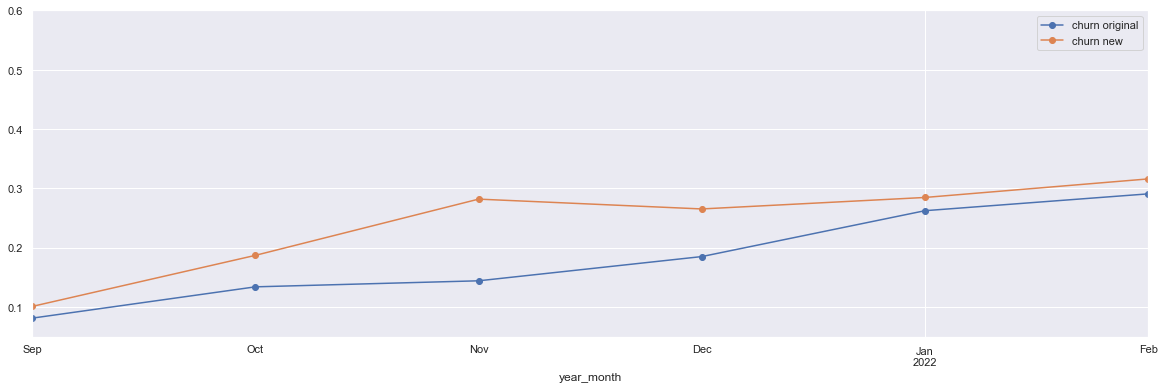

In [305]:
churn_distr[churn_distr['state'] == 'CA']['50%'].plot(marker = 'o',label = 'churn original')
churn_distr_short[churn_distr_short['state'] == 'CA']['50%'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.6)

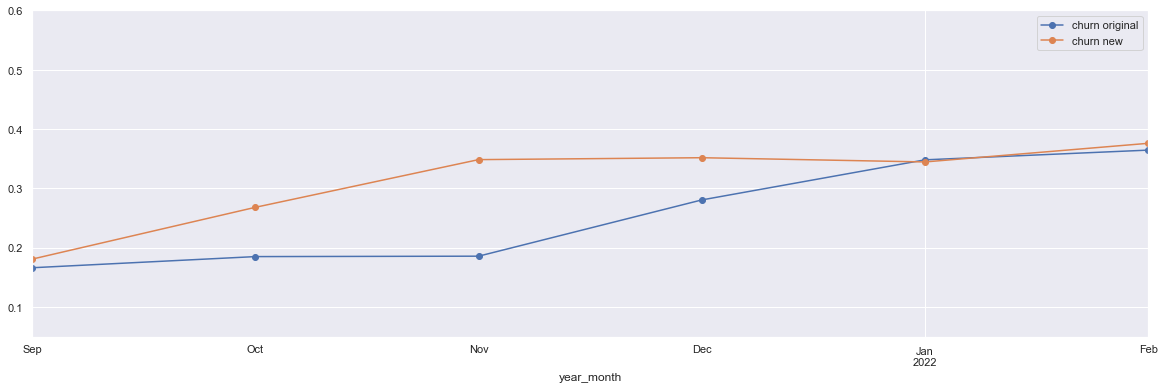

In [304]:
churn_distr[churn_distr['state'] == 'CA']['mean'].plot(marker = 'o',label = 'churn original')
churn_distr_short[churn_distr_short['state'] == 'CA']['mean'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.6)

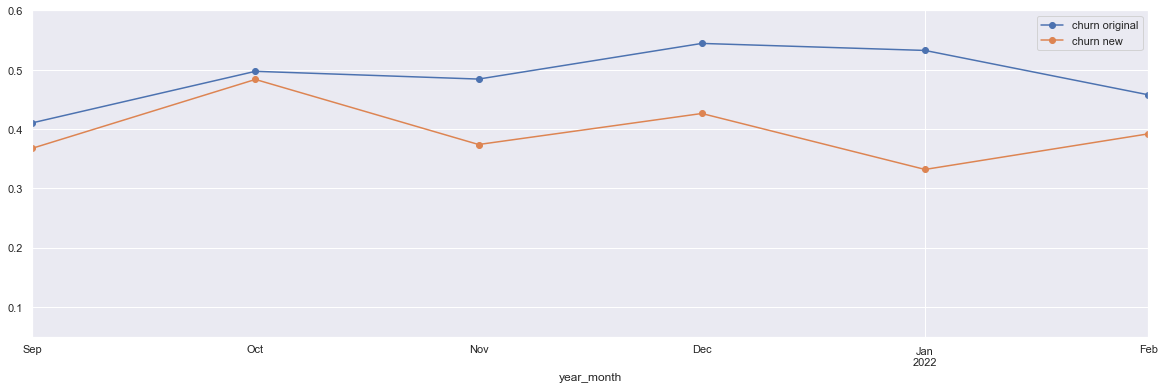

In [302]:
churn_distr[churn_distr['state'] == 'CO']['50%'].plot(marker = 'o',label = 'churn original')
churn_distr_short[churn_distr_short['state'] == 'CO']['50%'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.6)

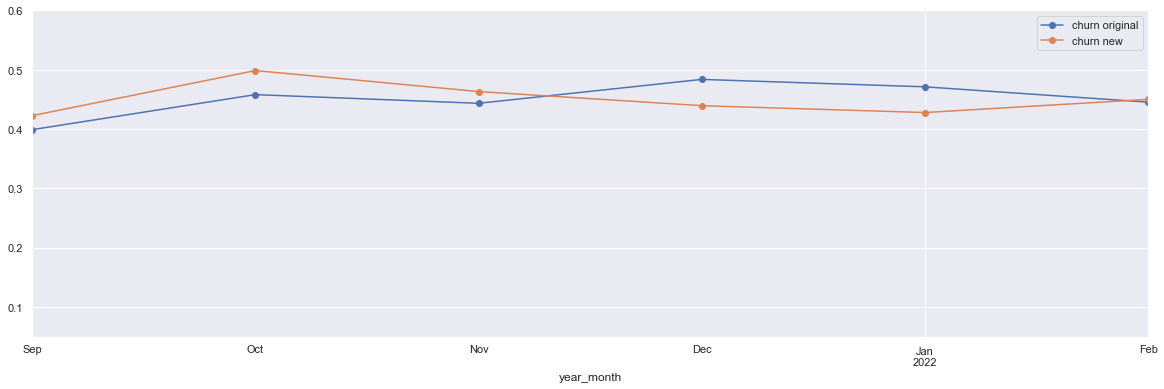

In [303]:
churn_distr[churn_distr['state'] == 'CO']['mean'].plot(marker = 'o',label = 'churn original')
churn_distr_short[churn_distr_short['state'] == 'CO']['mean'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.6)

# Qualification rate

In [207]:
df_clients = [
'DL',
'DW',
'EMA',
'EMM',
'EMT',
'EMF',
'ST',
'GRG',
'EL',
'VS',
'TT',
'MD',
'DWF',
'GHC',
'SV',
'99HT'
]

In [208]:
churn_joined_client = churn_joined[churn_joined['company_identifier'].isin(df_clients)]

In [211]:
churn_joined_client

,year_month,churn_orig,company,location,company_identifier,state,churn_new,new-old
0,2021-09-01,0.086819,99HT,C10-0000279-LIC,99HT,CA,0.268819,0.182000
1,2021-10-01,0.115768,99HT,C10-0000279-LIC,99HT,CA,0.299930,0.184162
2,2021-11-01,0.169809,99HT,C10-0000279-LIC,99HT,CA,0.315991,0.146182
3,2021-12-01,0.215134,99HT,C10-0000279-LIC,99HT,CA,0.357809,0.142675
4,2022-01-01,0.210160,99HT,C10-0000279-LIC,99HT,CA,0.295126,0.084966
...,...,...,...,...,...,...,...,...
871,2021-10-01,0.172940,VS,402R-00545,VS,CO,0.114183,-0.058756
872,2021-11-01,0.166993,VS,402R-00545,VS,CO,0.167247,0.000254
873,2021-12-01,0.161923,VS,402R-00545,VS,CO,0.163553,0.001631
874,2022-01-01,0.224073,VS,402R-00545,VS,CO,0.162052,-0.062021


In [212]:
# distribution of margin short for current df clients
churn_distr_short_df = churn_joined_client.groupby(['state','year_month'])['churn_new'].describe().reset_index()
churn_distr_short_df['year_month'] = pd.to_datetime(churn_distr_short_df['year_month'])
churn_distr_short_df.index = churn_distr_short_df.year_month


# distribution of margin orig for current df clients
churn_distr_df = churn_joined_client.groupby(['state','year_month'])['churn_orig'].describe().reset_index()
churn_distr_df['year_month'] = pd.to_datetime(churn_distr_df['year_month'])
churn_distr_df.index = churn_distr_df.year_month



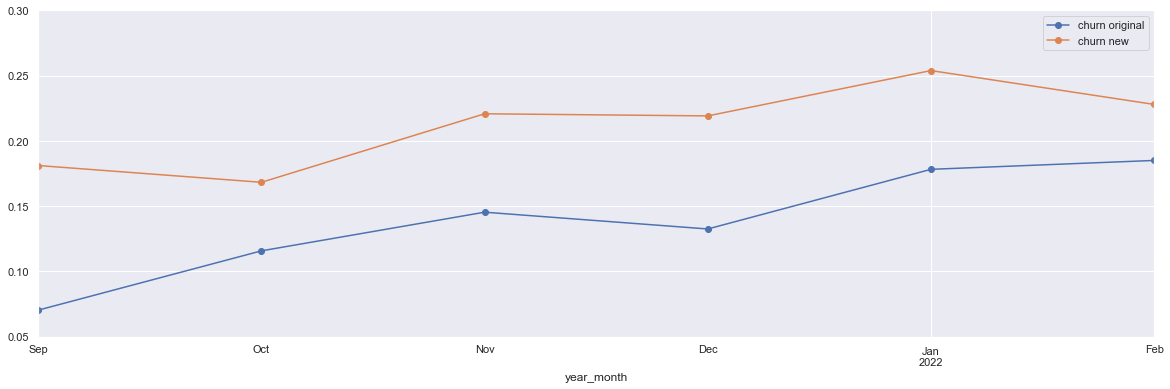

In [295]:
churn_distr_df[churn_distr_df['state'] == 'CA']['50%'].plot(marker = 'o',label = 'churn original')
churn_distr_short_df[churn_distr_short_df['state'] == 'CA']['50%'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.3)

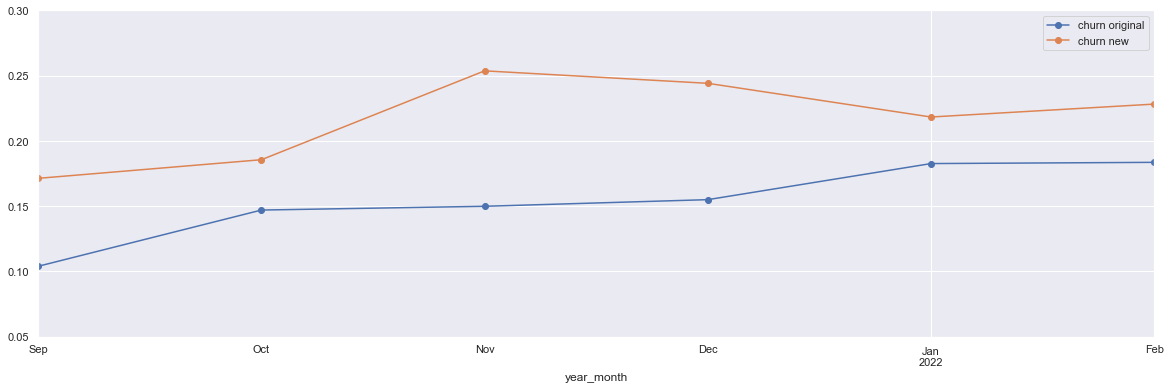

In [296]:
churn_distr_df[churn_distr_df['state'] == 'CA']['mean'].plot(marker = 'o',label = 'churn original')
churn_distr_short_df[churn_distr_short_df['state'] == 'CA']['mean'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.3)

In [311]:
churn_distr_df[churn_distr_df['state'] == 'CA']

,state,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,,
2021-09-01,CA,2021-09-01,13.0,0.103945,0.108485,0.0,0.026379,0.070324,0.150605,0.304961
2021-10-01,CA,2021-10-01,13.0,0.147036,0.136663,0.0,0.040579,0.115768,0.262152,0.425110
2021-11-01,CA,2021-11-01,13.0,0.149926,0.135177,0.0,0.038389,0.145397,0.249701,0.417880
2021-12-01,CA,2021-12-01,13.0,0.155007,0.139752,0.0,0.059869,0.132536,0.257432,0.453042
2022-01-01,CA,2022-01-01,13.0,0.182666,0.136093,0.0,0.130718,0.178262,0.262408,0.460428
2022-02-01,CA,2022-02-01,13.0,0.183607,0.131631,0.0,0.128248,0.185062,0.284150,0.446170


In [312]:
churn_distr_short_df[churn_distr_short_df['state'] == 'CA']

,state,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,,
2021-09-01,CA,2021-09-01,13.0,0.171353,0.141621,0.0,0.071074,0.181165,0.243229,0.507875
2021-10-01,CA,2021-10-01,13.0,0.185618,0.151917,0.0,0.087431,0.168319,0.240871,0.551159
2021-11-01,CA,2021-11-01,13.0,0.253743,0.228626,0.0,0.154711,0.220830,0.315991,0.818831
2021-12-01,CA,2021-12-01,13.0,0.244189,0.203369,0.0,0.165449,0.219206,0.347622,0.684729
2022-01-01,CA,2022-01-01,13.0,0.218354,0.152233,0.0,0.147499,0.253944,0.284730,0.544743
2022-02-01,CA,2022-02-01,13.0,0.228255,0.145975,0.0,0.212080,0.227998,0.316001,0.524251


In [314]:
churn_distr_df[churn_distr_df['state'] == 'CO']

,state,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,,
2021-09-01,CO,2021-09-01,3.0,0.089292,0.084786,0.013087,0.043627,0.074166,0.127394,0.180622
2021-10-01,CO,2021-10-01,3.0,0.084818,0.081914,0.010993,0.040758,0.070523,0.121731,0.172940
2021-11-01,CO,2021-11-01,3.0,0.115035,0.090347,0.010712,0.088852,0.166993,0.167197,0.167401
2021-12-01,CO,2021-12-01,3.0,0.184811,0.080814,0.117910,0.139917,0.161923,0.218262,0.274601
2022-01-01,CO,2022-01-01,3.0,0.199370,0.050305,0.141489,0.182781,0.224073,0.228311,0.232549
2022-02-01,CO,2022-02-01,3.0,0.200588,0.062229,0.130169,0.176791,0.223414,0.235797,0.248180


In [315]:
churn_distr_short_df[churn_distr_short_df['state'] == 'CO']

,state,year_month,count,mean,std,min,25%,50%,75%,max
year_month,,,,,,,,,,
2021-09-01,CO,2021-09-01,3.0,0.091601,0.011838,0.081740,0.085036,0.088332,0.096531,0.104730
2021-10-01,CO,2021-10-01,3.0,0.166311,0.048249,0.114183,0.144764,0.175345,0.192375,0.209405
2021-11-01,CO,2021-11-01,3.0,0.253605,0.078474,0.167247,0.220131,0.273014,0.296784,0.320553
2021-12-01,CO,2021-12-01,3.0,0.254061,0.079499,0.163553,0.224794,0.286035,0.299315,0.312594
2022-01-01,CO,2022-01-01,3.0,0.150075,0.036881,0.108695,0.135373,0.162052,0.170766,0.179480
2022-02-01,CO,2022-02-01,3.0,0.144756,0.052543,0.100056,0.115817,0.131578,0.167106,0.202634


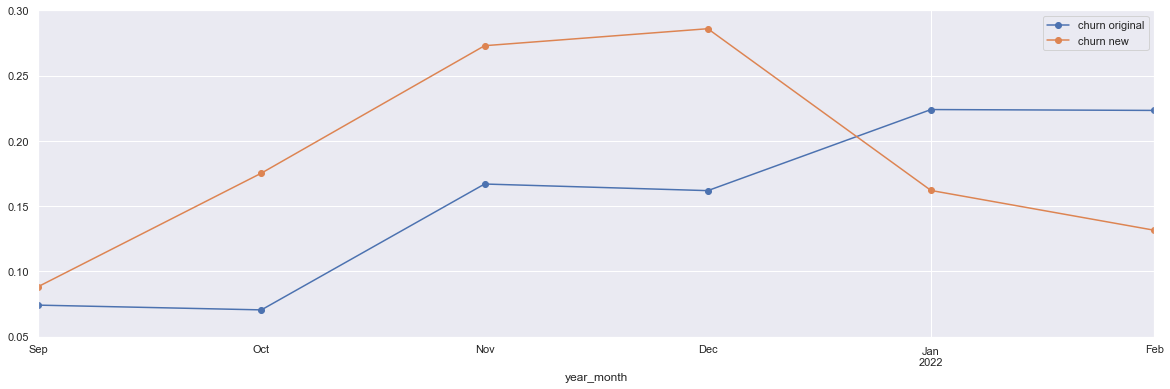

In [297]:
churn_distr_df[churn_distr_df['state'] == 'CO']['50%'].plot(marker = 'o',label = 'churn original')
churn_distr_short_df[churn_distr_short_df['state'] == 'CO']['50%'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.3)

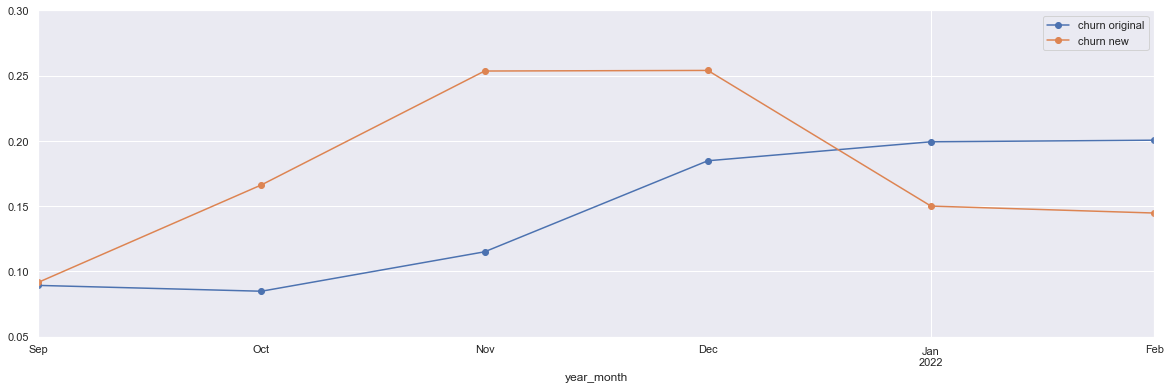

In [298]:
churn_distr_df[churn_distr_df['state'] == 'CO']['mean'].plot(marker = 'o',label = 'churn original')
churn_distr_short_df[churn_distr_short_df['state'] == 'CO']['mean'].plot(marker = 'o',label = 'churn new')
plt.legend()
ax = plt.ylim(0.05,0.3)

In [276]:
def calculate_monthly_qualification(data):
    q_df = {}
    nq_df = {}
    new_q_df = {}
    new_nq_df = {}
    
    q_2_nq_df = {}
    nq_2_q_df = {}
    for m in ['2021-09-01','2021-10-01','2021-11-01',\
             '2021-12-01','2022-01-01','2022-02-01']:
        
        d = data[data['year_month'] == m]
        qualify_list = d[d['churn_orig'] < 0.45]['company'].unique()
        non_qualify_list = d[d['churn_orig'] >= 0.45]['company'].unique()
        new_qualify_list = d[d['churn_new'] < 0.45]['company'].unique()
        new_non_qualify_list = d[d['churn_new'] >= 0.45]['company'].unique()
        
        q_df[m] = qualify_list
        nq_df[m] = non_qualify_list
        new_q_df[m] = new_qualify_list
        new_nq_df[m] = new_non_qualify_list
        
        q_2_nq = set(qualify_list) - set(new_qualify_list)
        nq_2_q = set(non_qualify_list) - set(new_non_qualify_list)
        
        q_2_nq_df[m] = q_2_nq
        nq_2_q_df[m] = nq_2_q
    return q_df,nq_df,new_q_df,new_nq_df,q_2_nq_df,nq_2_q

In [277]:
q,nq,new_q,new_nq,q_2_nq_data,nq_2_q_data = calculate_monthly_qualification(churn_joined_client)

In [317]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in q.items() ])).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
2021-09-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,ST,DW,TT,VS
2021-10-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,ST,DW,TT,VS
2021-11-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,ST,DW,TT,VS
2021-12-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS,NaN
2022-01-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS,NaN
2022-02-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,ST,DW,TT,VS


In [318]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in nq.items() ])).T

,0
2021-09-01,NaN
2021-10-01,NaN
2021-11-01,NaN
2021-12-01,ST
2022-01-01,ST
2022-02-01,NaN


In [319]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in new_q.items() ])).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
2021-09-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS
2021-10-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS
2021-11-01,99HT,DWF,DL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS,NaN
2021-12-01,99HT,DWF,DL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS,NaN
2022-01-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS
2022-02-01,99HT,DWF,DL,EL,EMA,EMF,EMM,EMT,GRG,GHC,MD,SV,DW,TT,VS


In [320]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in new_nq.items() ])).T

,0,1
2021-09-01,ST,NaN
2021-10-01,ST,NaN
2021-11-01,EL,ST
2021-12-01,EL,ST
2022-01-01,ST,NaN
2022-02-01,ST,NaN


In [227]:
churn_joined_client_feb

,year_month,churn_orig,company,location,company_identifier,state,churn_new,new-old
5,2022-02-01,0.189616,99HT,C10-0000279-LIC,99HT,CA,0.295449,0.105833
131,2022-02-01,0.130169,DWF,402R-00804,DWF,CO,0.202634,0.072465
149,2022-02-01,0.043769,DL,MR283369,DL,MA,0.111753,0.067984
197,2022-02-01,0.185062,EL,C9-0000370-LIC,EL,CA,0.324651,0.139589
203,2022-02-01,0.156166,EMA,C10-0000774-LIC,EMA,CA,0.238581,0.082415
209,2022-02-01,0.000000,EMF,C10-0000939-LIC,EMF,CA,0.000000,0.000000
215,2022-02-01,0.179660,EMM,C10-0000786-LIC,EMM,CA,0.340594,0.160934
221,2022-02-01,0.284150,EMT,C10-0000695-LIC,EMT,CA,0.212080,-0.072070
311,2022-02-01,0.290933,GRG,C10-0000169-LIC,GRG,CA,0.227998,-0.062935
317,2022-02-01,0.001028,GRG,C10-0000408-LIC,GRG,CA,0.006903,0.005875
